In [24]:
import pandas as pd
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

a-) Loading data & data pre-processing

In [25]:
# Loading data
trn_data = pd.read_csv('../data/train.csv')
tst_data = pd.read_csv('../data/test.csv')

##Precprocessing for train and validation
trn_data = processData(trn_data)
#Split training into training $ validation
val_data = trn_data.iloc[473:892,:] 
trn_data  = trn_data.iloc[0:473,:] 
## Preprocessing for test
tst_data = processData(tst_data)

print(f"Training data shape:{trn_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {tst_data.shape}")


# print(trn_data.head)
# print(val_data.head)




Training data shape:(473, 13)
Validation data shape: (418, 13)
Test data shape: (418, 12)


b-) input output split and training

In [26]:
y_trn = trn_data.pop('Survived').values
X_trn = trn_data.values

y_val = val_data.pop('Survived').values
X_val = val_data.values

# del trn_data
# del val_data


In [55]:
trn_data

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,22.00,1,0,7.2500,0,0,1,0,1,0,0,1
1,38.00,1,0,71.2833,1,0,0,1,0,1,0,0
2,26.00,0,0,7.9250,0,0,1,1,0,0,0,1
3,35.00,1,0,53.1000,1,0,0,1,0,0,0,1
4,35.00,0,0,8.0500,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
468,NaN,0,0,7.7250,0,0,1,0,1,0,1,0
469,0.75,2,1,19.2583,0,0,1,1,0,1,0,0
470,NaN,0,0,7.2500,0,0,1,0,1,0,0,1
471,38.00,0,0,8.6625,0,0,1,0,1,0,0,1


In [27]:
X_trn, y_trn = removeBadSamples(X_trn, y_trn)
X_val, y_val = removeBadSamples(X_val, y_val)
tst_data, blank = removeBadSamples(tst_data.values, 0)
print(X_trn.shape)
print(y_trn.shape)
print(tst_data.shape)


Original num of samples: 473
Found 96 bad samples
Will return 377 samples. Should be 377
Original num of samples: 418
Found 81 bad samples
Will return 337 samples. Should be 337
Original num of samples: 418
Found 87 bad samples
Will return 331 samples. Should be 331
(377, 12)
(377,)
(331, 12)
<ipython-input-3-ebf41066d709>:14: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  data = np.delete(data, nanRows[0:nans], 0)
<ipython-input-3-ebf41066d709>:15: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  labels = np.delete(labels, nanRows[0:nans], 0)
<ipython-input-3-ebf41066d709>:15: DeprecationWarning: in the future the special handling of scalars will be removed from delete and raise an error
  labels = np.delete(labels, nanRows[0:nans], 0)


In [43]:
class MNR_classifier:
    def __init__(self, C):
        self.W = None #Learned wents
        self.W_tild = None
        self.C = C #num of classes
        self.D = None #Dimenionality
        self.N = None #num of Samples
        self.T = None
        print(f"Initialized MNR for {self.C} class problem")

    def train(self, X, y, eta=0.001, max_iter=100000, plot=1, mu=-1, verbose=1):
        #Initialize model parameters
        self.initParams(X, y, verbose)
        if verbose:
            print(f"Training at rate: {eta}")
        step = 0
        steps = []
        ACEs = []
        # RACEs = []
        if (mu < 0):
            ACE = self.computeACE(X.T)
            # print(f"ACE: {ACE}" )
            while (ACE > 0.5):
                update = eta*self.gradient(X.T)
                self.W_tild = (self.W_tild.T - update).T #This is in (Cx(D+1))
                self.W = self.W_tild[:,0:self.D]
                ACE = self.computeACE(X.T)
                steps.append(step)
                ACEs.append(ACE)
                step += 1
                if (verbose):
                    print(f"ACE={ACE}, step={step}")
                    print("######################################")
                if (step >= max_iter):
                    break
        else:
            RACE = self.computeRACE(X.T, mu)
            # print(f"RACE: {RACE}" )
            while (RACE > 0.5):
                update = eta*self.Rgradient(X.T, mu)
                self.W_tild = (self.W_tild.T - update).T #This is in (Cx(D+1))
                self.W = self.W_tild[:,0:self.D]
                RACE = self.computeRACE(X.T, mu)
                steps.append(step)
                ACEs.append(RACE)
                step += 1
                if (verbose):
                    print(f"RACE={RACE}, step={step}")
                    print("######################################")
                if (step >= max_iter):
                    break
        if (plot):
            steps = np.array(steps)
            ACEs = np.array(ACEs)
            print("Steps:")
            print(steps)
            print("ACE's:")
            print(ACEs)
            plt.plot(steps, ACEs)
            plt.xlabel('Gradient descent iteration')
            plt.ylabel('Average Cross Entropy')
            plt.title('Training interation Vs. ACE')
            plt.show()
        # print(f"W_tild shape from train {self.W_tild.shape}")
        # print(f"W shape from train {self.W.shape}")

    def predict(self, X):
        X = X.T
        y_cat = self.softmax(X)
        y_hat = []
        for i in range(y_cat.shape[0]):
            y_hat.append(np.argmax(y_cat[i]))
        y_hat = np.array(y_hat)
        return y_hat

    def softmax(self, X):
        N =  X.shape[1]
        s = np.zeros((N, self.C))
        for i in range(0,self.C):
            for j in range(0,N):
                denom = (exp(self.h(X[:,j], self.W[0])) + exp(self.h(X[:,j], self.W[1])))
                s[j,i] = exp(self.h(X[:,j], self.W[i]))/denom
        return s #This will be in ((NxC))

    def gradient(self, X):
        X_tild = np.append(X, [np.ones(X.shape[1])], axis=0) #Augment design matrix
        S = self.softmax(X)
        gradM = (1/self.N)*(np.dot(X_tild, (S-self.T))) #This will be in ((D+1)xC)
        return gradM

    def Rgradient(self, X, mu):
        gr = self.gradient(X) #This is in ((D+1)xC)
        W = self.W.T
        zeros = np.zeros(self.C)
        W = np.append(W, [zeros], axis=0)
        Rgr = gr + 2*mu*W
        return Rgr #This is in ((D+1)xC)

    def computeRACE(self, X, mu):
        Wf2 =  np.trace(np.dot(self.W, self.W.T))
        ACE = self.computeACE(X)
        RACE = ACE + mu*Wf2
        return RACE

    def crossEntropy(self, x, y):
        i = np.where(y==1)[0][0]
        s = self.softmax(x)
        lce = -np.log(s)
        lce = lce[0][i]
        return lce

    def computeACE(self, X):
        tce = 0
        for i in range(self.N):
            x = X[:,i].reshape((self.D, 1))
            y = self.T[i]
            tce += self.crossEntropy(x,y)
        ACE = 1/self.N*(tce)
        return ACE
    
    def empirical_loss(self, x, y):
        h = self.h(x, self.W)
        # t = self.T[1]
        t = y.T
        # print("t")
        # print(t)
        y = np.argmax(t)
        k = (-1*(-1*(~y)-2)) #Flip decimal 1 to 0 and vice-versa
        l = 1 if (h[y]-h[k] < 0) else 0 #0/1 loss
        return l

    def evaluate(self, X, y, mu=-1):
        X = X.T
        l = 0
        N = X.shape[1]
        # print(f"Samples:{N}")
        for i in range(N):
            x = X[:,i]
            l += self.empirical_loss(x, y[i])
        return l/N

    def h(self, x, W):
        return np.dot(W,x)

    def initParams(self, X, y, verbose):
        self.N = X.shape[0]
        self.D = X.shape[1]
        self.W = np.random.rand(self.C, self.D) #Intializae with random weights
        self.W_tild = np.append(self.W, [[np.random.rand()],[np.random.rand()]], axis=1)
        self.T = y
        if verbose:
            print(f"Num of input samples: {self.N}\nDim of sample: {self.D}\nShape of W matrix: {self.W.shape}\nShape of W_tilde: {self.W_tild.shape}\nShape of one-hot y vector: {self.T.shape}")

    def RBF_transformation(self, X, X_= 0,s=6.0):
         N = X.shape[0]
         N_,X_ = (N,X) if not (hasattr(X_, "__len__")) else (X_.shape[0], X_) #Check if we are transforming a matrix that is not the traingin set
         print(f"Original design matrix: {X_.shape[0]}x{X_.shape[1]}")
         X_new = np.zeros((N,N_))
         for i in range(N_):
             for j in range(N):
                 X_new[j,i] = exp(-1*(np.linalg.norm(X_[i]-X[j])**2)/s)
         print(f"RBF transformed design matrix: {X_new.shape[0]}x{X_new.shape[1]}")
         return X_new

0.0001

7, step=3768
######################################
ACE=0.5032105666039155, step=3769
######################################
ACE=0.5031980916123626, step=3770
######################################
ACE=0.5031856212388289, step=3771
######################################
ACE=0.5031731554814254, step=3772
######################################
ACE=0.5031606943382653, step=3773
######################################
ACE=0.5031482378074598, step=3774
######################################
ACE=0.5031357858871239, step=3775
######################################
ACE=0.5031233385753718, step=3776
######################################
ACE=0.5031108958703192, step=3777
######################################
ACE=0.5030984577700818, step=3778
######################################
ACE=0.5030860242727762, step=3779
######################################
ACE=0.503073595376521, step=3780
######################################
ACE=0.5030611710794339, step=3781
######################################


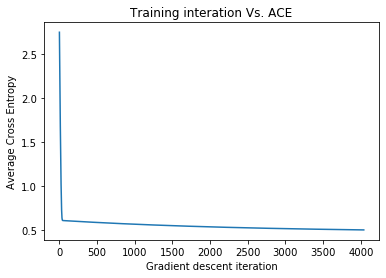

0/1 loss on trn set: 0.22281167108753316
0/1 loss on val set: 0.20474777448071216


In [44]:
#Vanilla MNR model
D=12
C = 2
N = 377
model = MNR_classifier(C=2)
model.train(X_trn, to_categorical(y_trn), eta=0.001, plot=1)
print(f"0/1 loss on trn set: {model.evaluate(X_trn, to_categorical(y_trn))}")
print(f"0/1 loss on val set: {model.evaluate(X_val, to_categorical(y_val))}")

Confusion matrix on training set

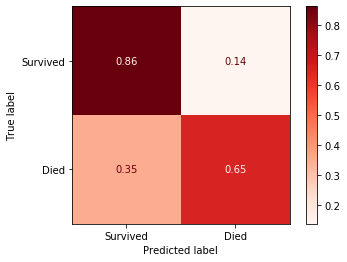

In [48]:
y_pred = model.predict(X_trn)
cm = confusion_matrix(y_trn, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Survived", "Died"])
# disp = disp.plot(cmap="YlOrBr")
disp = disp.plot(cmap="Reds")
plt.show()

In [ ]:
Confurion matrix on validation set

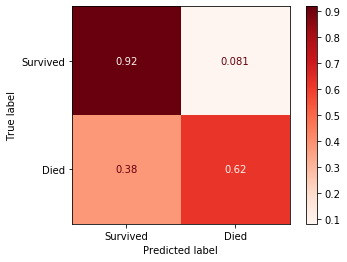

In [49]:
y_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Survived", "Died"])
# disp = disp.plot(cmap="YlOrBr")
disp = disp.plot(cmap="Reds")
plt.show()

In [53]:
    print("Survived class weights")
    print(model.W[0])
    print('__________')
    print("Died class weights")
    print(model.W[1])
    print('__________')
    print("Difference")
    print(model.W[0] - model.W[1])

Survived class weights
[ 0.62341708  0.43798325  0.67517337  0.24503854 -0.00949999  0.20593684
  0.47901734 -0.01629592  0.73447393  0.20891292  0.48451961  0.69128233]
__________
Died class weights
[0.59166996 0.27146682 0.31150035 0.25374409 0.35023714 0.7501052
 0.30493531 1.07396299 0.20988654 0.53020916 0.25435268 0.86382   ]
__________
Difference
[ 0.03174712  0.16651643  0.36367302 -0.00870555 -0.35973713 -0.54416836
  0.17408203 -1.09025891  0.52458739 -0.32129625  0.23016693 -0.17253766]


Task 4

a-) RBF Transformation

In [73]:
#RBF model
D=12
C = 2
N = 377
model = MNR_classifier(C=2)
X_trbf = model.RBF_transformation(X_trn)
X_trbf.shape


Initialized MNR for 2 class problem
Original design matrix: 377x12
RBF transformed design matrix: 377x377


(377, 377)

b-) Training RBF with $\mu = 0$ 

In [74]:
model.train(X_trbf.T, to_categorical(y_trn), eta=20, mu=0, plot=0)

Num of input samples: 377
Dim of sample: 377
Shape of W matrix: (2, 377)
Shape of W_tilde: (2, 378)
Shape of one-hot y vector: (377, 2)
Training at rate: 20
RACE=0.6341370111940197, step=1
######################################
RACE=0.6028035508871892, step=2
######################################
RACE=0.5753874831635126, step=3
######################################
RACE=0.5509037774506038, step=4
######################################
RACE=0.5287512851191022, step=5
######################################
RACE=0.5085180128191067, step=6
######################################
RACE=0.48990286144999445, step=7
######################################


c-) Find best $\mu$

Original design matrix: 337x12
RBF transformed design matrix: 377x337
<ipython-input-43-8f5bc6293947>:108: RuntimeWarning: divide by zero encountered in log
  lce = -np.log(s)
<ipython-input-3-ebf41066d709>:2: RuntimeWarning: overflow encountered in exp
  return np.exp(x)
<ipython-input-43-8f5bc6293947>:82: RuntimeWarning: invalid value encountered in double_scalars
  s[j,i] = exp(self.h(X[:,j], self.W[i]))/denom


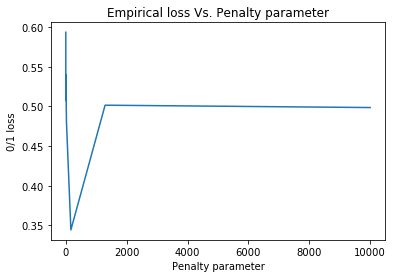

In [75]:
e = np.linspace(-4.0, 4.0, num=10)
L = np.zeros(len(e))
Mu = np.zeros(len(e))
X_vrbf = model.RBF_transformation(X_trn, X_=X_val)
for i in range(len(e)):
    mu = 10**e[i]
    Mu[i] = mu
    model.train(X_trbf.T, to_categorical(y_trn), eta=0.001, max_iter=100, mu=mu, plot=0, verbose=0)
    l = model.evaluate(X_vrbf.T, to_categorical(y_val))
    L[i] = l
plt.plot(Mu, L)
plt.xlabel('Penalty parameter')
plt.ylabel('0/1 loss')
plt.title('Empirical loss Vs. Penalty parameter')
plt.show()

In [76]:
#Find champion nu
# min_i = np.argmin(L)
ll = np.partition(L, 3)[1]
min_i = np.where(L==ll)
# np.partition(L, 2)[1]
best_mu = Mu[min_i]
best_mu[0]
# print(np.argmin(L))


21.54434690031882

d-) Compare MNR to best RBFNN

In [77]:
# Train model with champion nu
model.train(X_trbf.T, to_categorical(y_trn), eta=0.001, max_iter=100, mu=best_mu[0], plot=0, verbose=0)
tst_data_rbf = model.RBF_transformation(X_trn, X_=tst_data)

model1 = MNR_classifier(C=2)
#Train vanilla MNR model
model1.train(X_trn, to_categorical(y_trn), eta=0.001, max_iter=100, plot=0, verbose=0)

# model.evaluate(X_vrbf.T, to_categorical(y_val))
print(f"RBFNN 0/1 loss on test data: {model.evaluate(X_vrbf.T, to_categorical(y_val))}") #Bad result uses y_trn. Rewrite evaluate function
print(f"MNR 0/1 loss on test data: {model1.evaluate(X_val, to_categorical(y_val))}") #Bad result uses y_trn. Rewrite evaluate function
# model.evaluate(tst_data_rbf.T)

Original design matrix: 331x12
RBF transformed design matrix: 377x331
Initialized MNR for 2 class problem
RBFNN 0/1 loss on test data: 0.4599406528189911
MNR 0/1 loss on test data: 0.3887240356083086


ValueError: shapes (2,377) and (12,) not aligned: 377 (dim 1) != 12 (dim 0)

In [3]:
def exp(x):
    return np.exp(x)
    
def removeBadSamples(data, labels):
    num = data.shape[0]
    print(f"Original num of samples: {num}")
    nans = 0
    nanRows = np.zeros(100)
    for i in range(0, data.shape[0]):
        if (np.isnan(np.sum(data[i]))): #Check if sample contains nan
            nanRows[nans] = i #Store index of bad rows to delete later
            nans+=1
    print(f"Found {nans} bad samples")
    data = np.delete(data, nanRows[0:nans], 0)
    labels = np.delete(labels, nanRows[0:nans], 0)
    print(f"Will return {data.shape[0]} samples. Should be {num - nans}")
    return data, labels

def processData(data):
    # drop the droppables
    data.drop(['Name', 'Ticket', 'PassengerId', 'Cabin'], inplace=True, axis=1)
    # One hot encoding for categorical features
    onehot_Pclass = pd.get_dummies(data['Pclass'], prefix='Pclass')
    onehot_Sex = pd.get_dummies(data['Sex'], prefix='Sex')
    onehot_Emb = pd.get_dummies(data['Embarked'], prefix='Embarked')
    # Drop one hot encoded features
    data = pd.concat([data, onehot_Pclass, onehot_Sex, onehot_Emb], axis=1)
    data.drop(['Pclass', 'Sex', 'Embarked'], inplace=True, axis=1)

    return data

def h(W, x):
    return np.dot(W,x)